## FEDn API Example

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results

In [1]:
from fedn import APIClient
from fedn.dashboard.plots import Plot
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [2]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Here we initialize FEDn with a compute package and seed model from the mnist-pytorch example. Note that these files needs to be created separately by follwing instructions in the README of that example.

In [3]:
client.set_package('../mnist-pytorch/package.tgz', 'pytorchhelper')
client.set_initial_model('../mnist-pytorch/seed.npz')

{'message': 'Initial model added successfully.', 'success': True}

Next we start a training session:

In [4]:
session_config = {
                    "helper": "pytorchhelper",
                    "session_id": str(uuid.uuid4())  
                 }

result = client.start_session(**session_config)

In [11]:
validations = client.list_validations()
models = client.get_model_trail()

In [12]:
acc = collections.OrderedDict()
for id, validation in validations.items():
    metrics = json.loads(validation['data'])
    model_id = validation['model_id']
    try:
        acc[model_id].append(metrics['training_accuracy'])
    except KeyError: 
        acc[model_id] = [metrics['training_accuracy']]

print(acc)

OrderedDict([('9979d294-bf54-4d8d-b7d6-be499859b897', [0.367333322763443, 0.36899998784065247]), ('d4a611f6-bedb-4cc0-81c8-c6a3df909285', [0.4584999978542328, 0.4438333213329315]), ('5c74bdf8-f29d-4adc-bdf5-9a38ac1e2543', [0.5538333058357239, 0.5398333072662354]), ('5a7f64ca-6320-49a7-81f7-e1e09b5a75af', [0.715666651725769, 0.7070000171661377]), ('97c7f17c-6e59-4fe4-9ae8-b1bd1eb314d6', [0.7738333344459534, 0.765999972820282])])


In [13]:
mean_acc = []
for model, data in acc.items():
    mean_acc.append(np.mean(acc[model]))

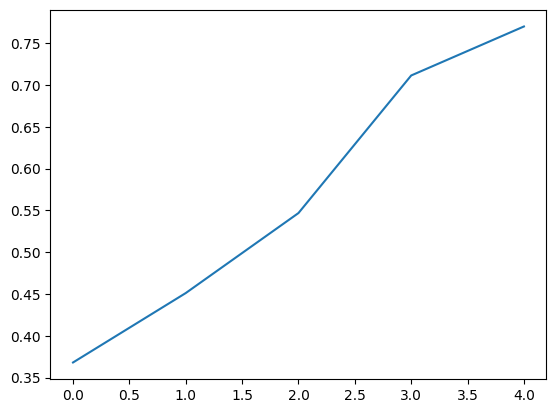

In [14]:
plt.plot(mean_acc)